In [1]:
# from google.colab import files
# uploaded = files.upload()

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
#Importing Required Libraries LSTM
import pandas as pd
import numpy as np
import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.layers.core import Dense, Activation, Dropout
# from keras.layers.recurrent import LSTM
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import Conv1D
import time

from sklearn.decomposition import PCA

2023-06-30 14:48:04.190632: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-30 14:48:04.395695: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/melodic/lib
2023-06-30 14:48:04.395716: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-30 14:48:05.525103: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared objec

In [3]:
from pyspark.sql import functions as sf

In [4]:
import joblib

In [5]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [30]:
from pyspark.sql import SparkSession
# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Read JSON file into DataFrame
json_file_path = "/home/vannini/harpia/flight_data.json"
df = spark.read.json(json_file_path)


df_s = df.select(
    "id",
    "Type",
    "error",
    sf.explode("data").alias("data")
).select(
    "id",
    "Type",
    "error",
    sf.col("data.roll").alias("roll"),
    sf.col("data.pitch").alias("pitch"),
    sf.col("data.yaw").alias("yaw"),
    sf.col("data.heading").alias("heading"),
    sf.col("data.rollRate").alias("rollRate"),
    sf.col("data.pitchRate").alias("pitchRate"),
    sf.col("data.yawRate").alias("yawRate"),
    sf.col("data.groundSpeed").alias("groundSpeed"),
    sf.col("data.climbRate").alias("climbRate"),
    sf.col("data.altitudeRelative").alias("altitudeRelative"),
    sf.col("data.throttlePct").alias("throttlePct")
)
# df_s.printSchema()
# Print the DataFrame
# df.show()

In [31]:
df_s.show()

+---+-------------------+-----+--------------------+--------------------+----+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+
| id|               Type|error|                roll|               pitch| yaw|           heading|            rollRate|           pitchRate|             yawRate|         groundSpeed|           climbRate|    altitudeRelative|       throttlePct|
+---+-------------------+-----+--------------------+--------------------+----+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+
|  0|Takeoff and landing| true|  0.0160099285079197|-0.00726505465933...|null|461.20050024305567|-9.80036708636525...|-0.00552425785785...|-0.01129696558460...| 0.12141013458125746| -0.4419510988008492|-0.10362918471831066|               0.0|
|  0|Takeoff and landing| tr

In [32]:
df_s.groupBy('id').count().groupBy().avg().show()

+-------+-----------------+
|avg(id)|       avg(count)|
+-------+-----------------+
|  257.0|92.00388349514563|
+-------+-----------------+



In [9]:
def info(df):
  print(df.info(verbose=True))
  return None

In [10]:
def nulls_qtd(df):
  print(df.isna().sum())
  return None

In [11]:
def describe(df, perc, drop_list = None):
  if drop_list == None:
    df.select_dtypes(include='number').describe(percentiles = perc)
  else:
    df.select_dtypes(include='number').drop(drop_list, axis=1).describe(percentiles = perc)
  return None

In [11]:
df_s.show()

+---+-------------------+-----+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+
| id|               Type|error|                roll|               pitch|               yaw|            rollRate|           pitchRate|             yawRate|         groundSpeed|           climbRate|    altitudeRelative|       throttlePct|
+---+-------------------+-----+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+
|  0|Takeoff and landing| true|  0.0160099285079197|-0.00726505465933...|461.20050024305567|-9.80036708636525...|-0.00552425785785...|-0.01129696558460...| 0.12141013458125746| -0.4419510988008492|-0.10362918471831066|               0.0|
|  0|Takeoff and landing| true|0.016027034943085

In [12]:
def shape(df):
  # DataFrame shape
  print(f'Rows: {df.shape[0]}\n   \nColumns: {df.shape[1]}')
  return None

In [13]:
def select_columns(df, columns_names_list):
  df_new = df[columns_names_list]
  return df_new

In [14]:
def split_train_test(X, y, strat, perc = 0.25):
  """
  X: x's variables
  y: target variable (system response)
  perc: test data percentage (decimal value; default = 0.2 = 20% of data)
  """
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=strat)

  # Resets all DFs indexes
  X_train.reset_index(drop = True, inplace = True)
  X_test.reset_index(drop = True, inplace = True)
  y_train.reset_index(drop = True, inplace = True)
  y_test.reset_index(drop = True, inplace = True)

  return X_train, X_test, y_train, y_test

# 2- Exploratory Data Analysis (EDA)

In [33]:
df = df_s.toPandas()
df.head()

,id,Type,error,roll,pitch,yaw,heading,rollRate,pitchRate,yawRate,groundSpeed,climbRate,altitudeRelative,throttlePct
0,0,Takeoff and landing,True,0.016010,-0.007265,NaN,461.200500,-0.000980,-0.005524,-0.011297,0.121410,-0.441951,-0.103629,0.000000
1,0,Takeoff and landing,True,0.016027,-0.005862,NaN,461.051960,-0.001250,0.000677,-0.003737,0.160009,-0.443906,0.004935,0.838891
2,0,Takeoff and landing,True,0.015220,-0.004188,NaN,460.996826,0.000472,0.003879,-0.019766,0.128934,-0.406455,-0.004935,1.924491
3,0,Takeoff and landing,True,0.014331,-0.005217,NaN,460.898682,-0.002041,-0.004281,-0.004010,0.065151,-0.339478,-0.009869,2.664697
4,0,Takeoff and landing,True,-0.115646,-0.202248,NaN,461.743322,-0.290028,-0.249074,-0.040604,0.269550,0.292084,0.078955,3.602067


In [34]:
df[df['error']==False].describe()

,id,roll,pitch,yaw,heading,rollRate,pitchRate,yawRate,groundSpeed,climbRate,altitudeRelative,throttlePct
count,33017.000000,33017.000000,33017.000000,33017.000000,33017.000000,33017.000000,33017.000000,33017.000000,33017.000000,33017.000000,33017.000000,33017.000000
mean,207.405155,0.000806,0.002833,0.844894,115.250263,0.000154,-0.000066,-0.000037,0.037203,-0.111073,-0.528727,0.012212
std,165.402414,0.008437,0.009592,0.762674,129.866613,0.001544,0.001591,0.001599,0.022983,0.082060,0.423008,0.036281
min,6.000000,-0.020466,-0.023518,-0.061491,0.000000,-0.004801,-0.004413,-0.004161,0.000375,-0.234207,-0.971000,0.000000
25%,66.000000,-0.005022,-0.004126,0.075876,0.080000,-0.000828,-0.001275,-0.001214,0.018749,-0.173954,-0.817000,0.000000
50%,134.000000,0.000648,0.002261,1.568556,85.260002,0.000223,-0.000081,-0.000036,0.033824,-0.138986,-0.756000,0.000000
75%,370.000000,0.007013,0.009642,1.570579,92.820000,0.001211,0.001067,0.000924,0.050225,-0.063068,0.024000,0.000000
max,514.000000,0.023513,0.027969,1.581190,359.989990,0.004769,0.005313,0.004973,0.128819,0.135915,0.361000,0.120000


In [35]:
df[df['error']==True].describe()

,id,roll,pitch,yaw,heading,rollRate,pitchRate,yawRate,groundSpeed,climbRate,altitudeRelative,throttlePct
count,14365.000000,14365.000000,14365.000000,0.0,14365.000000,14365.000000,14365.000000,14365.000000,14365.000000,14365.000000,14365.000000,14365.000000
mean,195.420814,0.005449,0.025506,NaN,735.734097,-0.000550,0.005557,0.001593,6.001710,-0.179220,38.257504,3.387154
std,164.287193,0.434786,0.457408,NaN,699.536821,0.770115,0.794651,0.084414,7.555147,2.205264,36.822243,0.491505
min,0.000000,-1.895378,-1.931535,NaN,0.000000,-2.660523,-2.954048,-0.675547,0.000929,-6.530260,-6.266885,0.000000
25%,60.000000,-0.031026,-0.041849,NaN,416.440885,-0.023051,-0.022239,-0.007898,0.156115,-0.324221,14.393404,3.454232
50%,124.000000,0.001032,-0.000912,NaN,439.583728,-0.000062,0.000535,-0.000100,0.739665,-0.002159,29.682999,3.454312
75%,356.000000,0.038860,0.040421,NaN,1775.580784,0.023651,0.024089,0.007864,12.177888,0.287359,49.421213,3.503660
max,500.000000,1.898162,1.912334,NaN,1776.495326,2.641717,2.840332,4.658103,24.298469,14.658489,213.289180,4.391864


In [36]:
df.pipe(shape)

Rows: 47382
   
Columns: 14


In [37]:
df.pipe(info)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47382 entries, 0 to 47381
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                47382 non-null  int64  
 1   Type              47382 non-null  object 
 2   error             47382 non-null  bool   
 3   roll              47382 non-null  float64
 4   pitch             47382 non-null  float64
 5   yaw               33017 non-null  float64
 6   heading           47382 non-null  float64
 7   rollRate          47382 non-null  float64
 8   pitchRate         47382 non-null  float64
 9   yawRate           47382 non-null  float64
 10  groundSpeed       47382 non-null  float64
 11  climbRate         47382 non-null  float64
 12  altitudeRelative  47382 non-null  float64
 13  throttlePct       47382 non-null  float64
dtypes: bool(1), float64(11), int64(1), object(1)
memory usage: 4.7+ MB
None


In [38]:
df.pipe(nulls_qtd)

id                      0
Type                    0
error                   0
roll                    0
pitch                   0
yaw                 14365
heading                 0
rollRate                0
pitchRate               0
yawRate                 0
groundSpeed             0
climbRate               0
altitudeRelative        0
throttlePct             0
dtype: int64


In [41]:
df[df["yaw"].isnull()]["id"].nunique()

156

In [43]:
df["yaw"] = df["yaw"].fillna(0)

<AxesSubplot:>

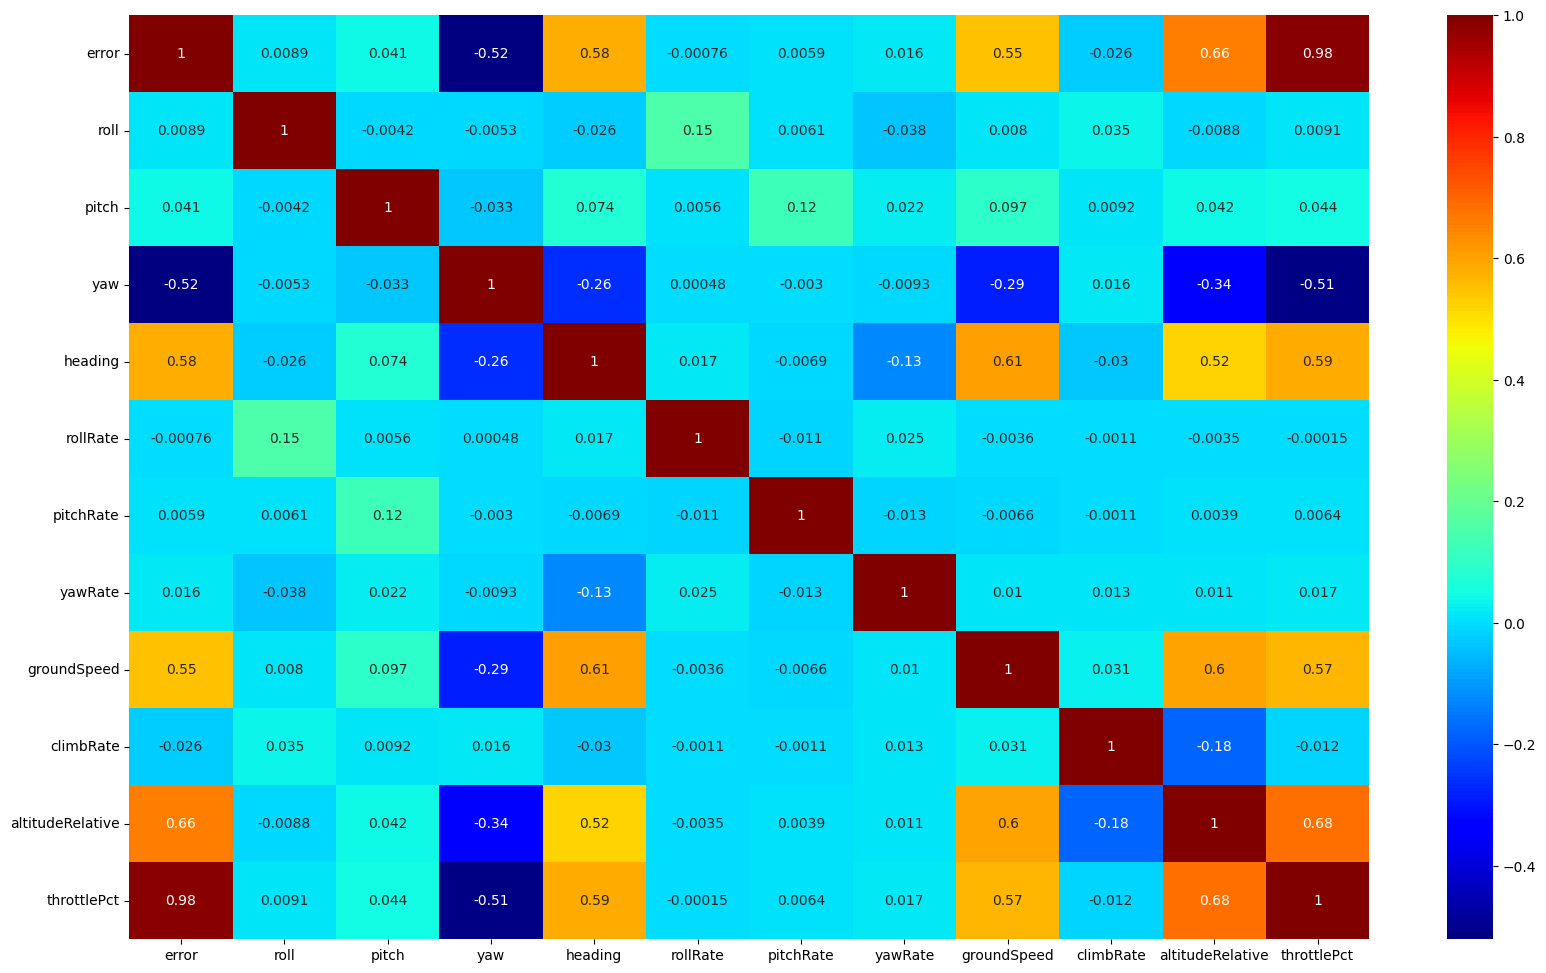

In [44]:
plt.figure(figsize=(20,12))
sns.heatmap(df.drop(['id'], axis=1).corr(), annot=True, cmap='jet')

# 3- Anomaly Detection (LSTM)

In [45]:
df_reduced = df.pipe(select_columns, ['roll', 'pitch', 'yaw', 'error'])
df_reduced.loc[:,'error'] = df_reduced['error'].astype(int)
df_reduced

/home/vannini/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,roll,pitch,yaw,error
0,0.016010,-0.007265,0.000000,1
1,0.016027,-0.005862,0.000000,1
2,0.015220,-0.004188,0.000000,1
3,0.014331,-0.005217,0.000000,1
4,-0.115646,-0.202248,0.000000,1
...,...,...,...,...
47377,-0.008456,0.008655,1.567685,0
47378,-0.008456,0.008655,1.567685,0
47379,-0.008456,0.008655,1.567685,0
47380,-0.008456,0.008655,1.567685,0


In [46]:
#Preparing the data for LSTM model
data_n = df_reduced
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled, columns=data_n.columns)
data_n

,roll,pitch,yaw,error
0,0.057604,-0.067298,-0.789484,1.516059
1,0.057676,-0.061733,-0.789484,1.516059
2,0.054305,-0.055095,-0.789484,1.516059
3,0.050593,-0.059178,-0.789484,1.516059
4,-0.492098,-0.840460,-0.789484,1.516059
...,...,...,...,...
47377,-0.044548,-0.004169,1.312723,-0.659605
47378,-0.044548,-0.004169,1.312723,-0.659605
47379,-0.044548,-0.004169,1.312723,-0.659605
47380,-0.044548,-0.004169,1.312723,-0.659605


In [79]:
data_n.describe()

,roll,pitch,yaw,error
count,4.738200e+04,4.738200e+04,4.738200e+04,4.738200e+04
mean,-7.198103e-18,-4.798735e-18,1.919494e-17,-8.157850e-17
std,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00
min,-7.923031e+00,-7.697578e+00,-8.719406e-01,-6.596051e-01
25%,-3.817456e-02,-6.508191e-02,-7.894836e-01,-6.596051e-01
50%,-6.491266e-03,-3.014948e-02,-6.799582e-01,-6.596051e-01
75%,2.938455e-02,9.896253e-03,1.315900e+00,1.516059e+00
max,7.916171e+00,7.544461e+00,1.330833e+00,1.516059e+00


In [47]:
df_pca_input = df.pipe(select_columns, ['roll','pitch','yaw','rollRate','pitchRate','yawRate','climbRate','groundSpeed'])

In [48]:
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(df_pca_input)
data_scaled_pca = pd.DataFrame(np_scaled)

In [49]:
pca = PCA(n_components = 3)
pca.fit(data_scaled_pca)

PCA(n_components=3)

In [50]:
df_pca = pca.transform(data_scaled_pca)


# LSTM Model - Pitch/Row/Yaw

In [51]:
x = data_n.drop(['error'],axis=1)
y = data_n.error

print(x.head())
print('\n\n')
print(y.head())

       roll     pitch       yaw
0  0.057604 -0.067298 -0.789484
1  0.057676 -0.061733 -0.789484
2  0.054305 -0.055095 -0.789484
3  0.050593 -0.059178 -0.789484
4 -0.492098 -0.840460 -0.789484



0    1.516059
1    1.516059
2    1.516059
3    1.516059
4    1.516059
Name: error, dtype: float64


In [52]:
# from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=33)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(35536, 3)
(35536,)
(11846, 3)
(11846,)


In [53]:
# Convert X_train and X_test to NumPy arrays
x_train = x_train.values
x_test = x_test.values

# Reshape your input data
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# Reshape y_train
y_train = np.array(y_train)
y_train = np.reshape(y_train, (y_train.shape[0], 1))

# Reshape y_test
y_test = np.array(y_test)
y_test = np.reshape(y_test, (y_test.shape[0], 1))

In [54]:
sz = x_train.shape[0] + x_test.shape[0]

print(f'Train relation: {(x_train.shape[0]/sz)*100}% of the data')
print(f'Test relation: {(x_test.shape[0]/sz)*100}% of the data')

Train relation: 74.99894474695031% of the data
Test relation: 25.00105525304968% of the data


In [55]:
#Building the model
model = Sequential()


model.add(LSTM(360, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

compilation time : 0.02238750457763672


In [56]:
model.fit(x_train, y_train, batch_size=60, epochs=30, validation_split=0.1)

Epoch 1/30
534/534 [==============================] - 42s 70ms/step - loss: 0.6391 - val_loss: 0.5643
Epoch 2/30
534/534 [==============================] - 42s 79ms/step - loss: 0.4933 - val_loss: 0.3895
Epoch 3/30
534/534 [==============================] - 39s 72ms/step - loss: 0.3009 - val_loss: 0.3190
Epoch 4/30
534/534 [==============================] - 35s 65ms/step - loss: 0.2226 - val_loss: 0.1693
Epoch 5/30
534/534 [==============================] - 37s 69ms/step - loss: 0.1975 - val_loss: 0.1568
Epoch 6/30
534/534 [==============================] - 35s 65ms/step - loss: 0.1857 - val_loss: 0.1480
Epoch 7/30
534/534 [==============================] - 34s 63ms/step - loss: 0.1816 - val_loss: 0.1467
Epoch 8/30
534/534 [==============================] - 36s 67ms/step - loss: 0.1745 - val_loss: 0.1437
Epoch 9/30
534/534 [==============================] - 31s 59ms/step - loss: 0.1692 - val_loss: 0.1610
Epoch 10/30
534/534 [==============================] - 33s 61ms/step - loss: 0.163

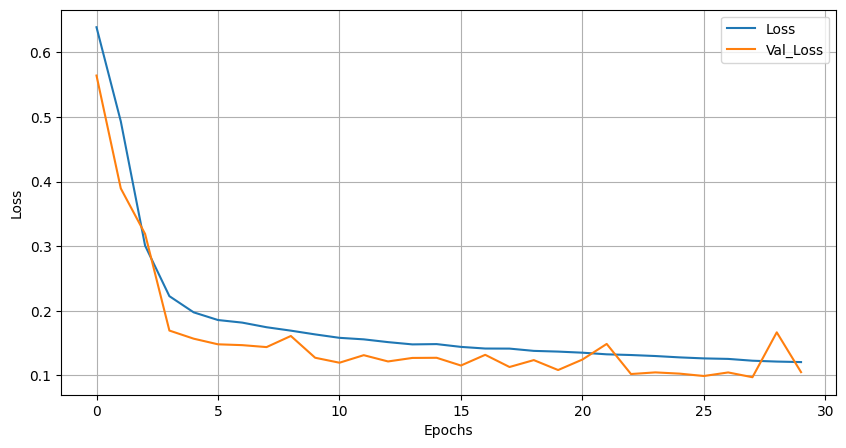

In [57]:
#Visualizing training and validaton loss
plt.figure(figsize = (10, 5))
plt.plot(model.history.history['loss'], label = 'Loss')
plt.plot(model.history.history['val_loss'], label = 'Val_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

In [58]:
y_pred = model.predict(x_test)

371/371 [==============================] - 8s 16ms/step


In [59]:
threshold = 0
softmax_pred = np.where(y_pred[:, 0] >= threshold, 1, 0)

In [60]:
softmax_test = np.where(y_test[:, 0] >= threshold, 1, 0)

In [39]:
data_n.groupby('error').size().reset_index(name='count')

,error,count
0,-0.659605,33017
1,1.516059,14365


In [40]:
df.groupby('error').size().reset_index(name='count')

,error,count
0,False,33017
1,True,14365


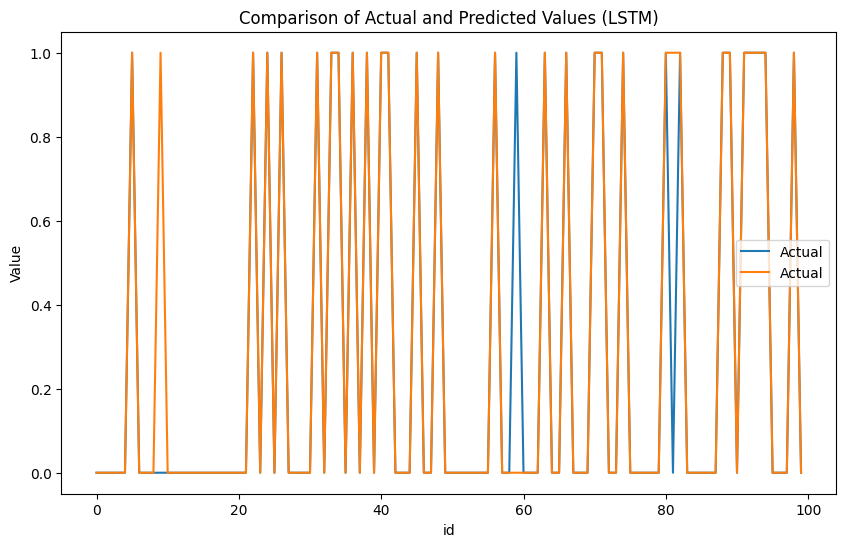

In [61]:
# Plotting the comparison
plt.figure(figsize=(10, 6))
plt.plot(softmax_pred[500:600], label='Actual')
plt.plot(softmax_test[500:600], label='Actual')
# plt.plot(y_test[500:600], label='Actual')
# plt.plot(y_pred[500:600], label='Predicted')
plt.xlabel('id')
plt.ylabel('Value')
plt.title('Comparison of Actual and Predicted Values (LSTM)')
plt.legend()
plt.show()

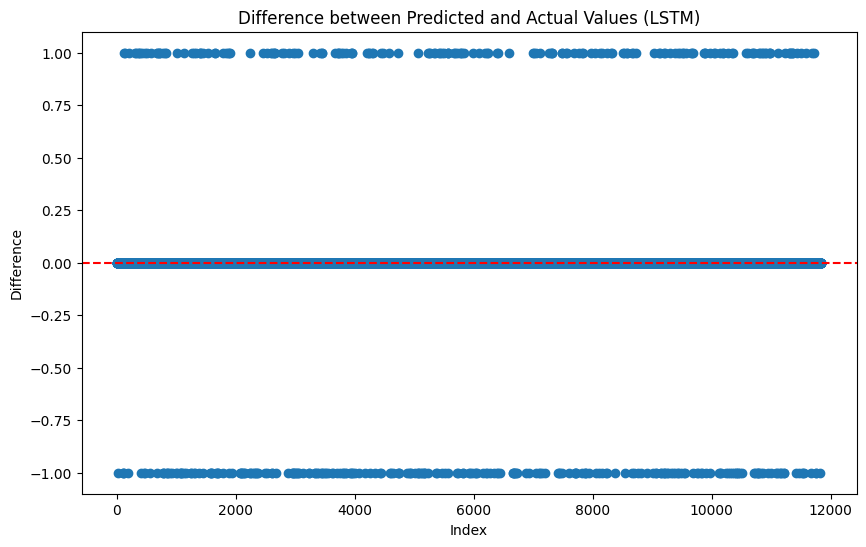

In [62]:
# Calculate the difference between predicted and actual values
difference = softmax_test - softmax_pred

# Plotting the difference as a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(range(len(difference)), difference)
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.xlabel('Index')
plt.ylabel('Difference')
plt.title('Difference between Predicted and Actual Values (LSTM)')
plt.show()

In [63]:
np.sum(np.abs(difference))/len(difference)*100

3.7058922843153805

In [64]:
# ser'a q os erros estao muito suaves? ou muito absurdos?
## procurar base na internet com erro de pitch, roll e yaw

In [65]:
len(difference)

11846

In [66]:
df.groupby('error').count()

,id,Type,roll,pitch,yaw,heading,rollRate,pitchRate,yawRate,groundSpeed,climbRate,altitudeRelative,throttlePct
error,,,,,,,,,,,,,
False,33017,33017,33017,33017,33017,33017,33017,33017,33017,33017,33017,33017,33017
True,14365,14365,14365,14365,14365,14365,14365,14365,14365,14365,14365,14365,14365


> Exporting Model

In [69]:
filename = "LSTM_predictions1.joblib"
joblib.dump(model, filename)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......dense
.........vars
............0
............1
......dropout
.........vars
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
...metrics
......mean
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-06-30 15:52:20         2038
metadata.json                                  2023-06-30 15:52:20           64
variables.h5                                   2023-06-30 15:52:20      4195616


['LSTM_predictions1.joblib']

In [70]:
loaded_LSTM = joblib.load(filename)

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-06-30 15:52:20         2038
metadata.json                                  2023-06-30 15:52:20           64
variables.h5                                   2023-06-30 15:52:20      4195616
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......activation
.........vars
......dense
.........vars
............0
............1
......dropout
.........vars
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
...metrics
......mean
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
...vars


In [81]:
data_n.drop(['error'],axis=1).values

array([[ 0.05760411, -0.06729817, -0.78948365],
       [ 0.05767553, -0.06173336, -0.78948365],
       [ 0.05430535, -0.05509496, -0.78948365],
       ...,
       [-0.04454806, -0.00416864,  1.31272319],
       [-0.04454806, -0.00416864,  1.31272319],
       [-0.04454806, -0.00416864,  1.31272319]])

In [83]:
test = [[-0.008122967793406688,-0.031792852469140896,-1.175610922771928]]
y_pred = loaded_LSTM.predict(test)

1/1 [==============================] - 0s 92ms/step


In [84]:
y_pred

array([[0.40284377]], dtype=float32)

In [73]:
y_pred = loaded_LSTM.predict(data_n.drop(['error'],axis=1).values)

1481/1481 [==============================] - 21s 14ms/step


In [74]:
y_pred

array([[ 0.19230366],
       [ 0.14232454],
       [ 0.03937024],
       ...,
       [-0.76590264],
       [-0.76590264],
       [-0.76590264]], dtype=float32)

In [75]:
threshold = 0
softmax_pred = np.where(y_pred[:, 0] >= threshold, 1, 0)

In [76]:
softmax_test = np.where(data_n["error"].values >= threshold, 1, 0)

In [77]:
difference = softmax_test - softmax_pred

In [78]:
(np.sum(difference)/len(difference))*100

-0.4453167869655143